In [1]:
import os
import sys
import numpy as np
from numpy.random import randint, choice, randn
import torch
import skimage.morphology
from skimage.morphology import ball, octahedron, cube
from matplotlib import cm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
from   scipy.stats import lognorm
import torch.special as S
from fft_conv_pytorch import fft_conv

In [2]:
def make_ball(r = 20, datasize = [128, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data).to(torch.float32)
    data = data.unsqueeze(0)
    return data

In [3]:
data = make_ball(r=20, datasize=[240, 128, 128])
nd_data = data.detach().numpy().copy()

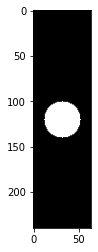

In [4]:
plt.imshow(data[0, :, 64, 32:96], cmap='gray', vmax=1, vmin=0)

In [5]:
class Emission(nn.Module):
    def __init__(self, mu_z, sig_z, log_ez0):
        super().__init__()
        self.mu_z     = mu_z
        self.sig_z    = sig_z
        self.log_ez0  = log_ez0
        #self.mu_z_    = mu_z.item()
        #self.sig_z_   = sig_z.item()
        #self.logn_ppf = lognorm.ppf([0.99], 1,
        #                    loc=self.mu_z_, scale=self.sig_z_)[0]
        
    def sample(self, x):
        b = x.shape[0]
        mu_z   = torch.tensor(self.mu_z )
        sig_z  = torch.tensor(self.sig_z) 
        pz0  = dist.LogNormal(loc   = mu_z.view( b, 1, 1, 1, 1).expand(*x.shape),
                              scale = sig_z.view(b, 1, 1, 1, 1).expand(*x.shape),)
        x    = x * pz0.sample().to(x.device)
        x    = torch.clip(x, min=0, max=1)
        #x    = x / self.logn_ppf
        return x

    def forward(self, x):
        x = x * torch.exp(self.log_ez0)
        return x


class Intensity(nn.Module):
    def __init__(self, gamma, image_size, initial_depth, voxel_size, scale,
                 device):
        super().__init__()
        init_d = initial_depth
        im_z,  \
        im_x,  \
        im_y   = image_size
        end_d  = im_z * voxel_size * scale
        depth  = init_d \
               + torch.linspace(0, end_d, im_z,).view(-1,1,1,).to(device)
        _intensity = torch.exp(-2 * depth * gamma) # gamma = 0.005
        self._intensity = _intensity.expand(image_size)

    def forward(self, x):
         x = x * self.intensity
         return x

    @property
    def intensity(self):
        return self._intensity


class Blur(nn.Module):
    def __init__(self, z, x, y, log_bet_z, log_bet_xy, scale, device,
                 psf_mode:str="double_exp", apply_hill=False, use_fftconv=False):
        super().__init__()
        self.log_bet_z   = log_bet_z
        self.log_bet_xy  = log_bet_xy
        self.zscale, \
        self.xscale, \
        self.yscale  = scale
        self.z       = z
        self.x       = x
        self.y       = y
        self.device  = device
        self.zd      = self.distance(z)
        self.dp      = self.gen_distance_plane(xlen=x, ylen=y)
        self.mode    = psf_mode
        bet_xy       = torch.exp(self.log_bet_xy)
        bet_z        = torch.exp(self.log_bet_z )
        self.psf     = self.gen_psf(bet_xy, bet_z).to(device)
        self.z_pad   = (z - self.zscale + 1) // 2
        self.x_pad   = (x - self.xscale + 1) // 2
        self.y_pad   = (y - self.yscale + 1) // 2
        self.stride  = (self.zscale, self.xscale, self.yscale)
        self.apply_hill = apply_hill
        self.use_fftconv = use_fftconv

    def forward(self, x):
        x_shape = x.shape
        bet_xy  = torch.exp(self.log_bet_xy)
        bet_z   = torch.exp(self.log_bet_z )
        psf = self.gen_psf(bet_xy, bet_z).to(self.device)
        if self.use_fftconv:
            _x   = fft_conv(signal  = x                                    ,
                            kernel  = psf                                  ,
                            stride  = self.stride                          ,
                            padding = (self.z_pad, self.x_pad, self.y_pad,),
                            )
        else:
            _x   = F.conv3d(input   = x                                    ,
                            weight  = psf                                  ,
                            stride  = self.stride                          ,
                            padding = (self.z_pad, self.x_pad, self.y_pad,),
                            )
        return _x

    def gen_psf(self, bet_xy, bet_z):
        if bet_xy.shape:
            b = bet_xy.shape[0]
        else:
            b = 1
        psf_lateral = self.gen_2dnorm(self.dp, bet_xy, b)[:, None, None,    :,    :]
        psf_axial   = self.gen_1dnorm(self.zd, bet_z , b)[:, None,    :, None, None]
        psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial)) # log-sum-exp technique
        psf = psf / torch.sum(psf)
        return psf

    def _init_distance(self, length):
        return torch.zeros(length)

    def _distance_from_center(self, index, length):
        return abs(index - length // 2)

    def distance(self, length):
        distance = torch.zeros(length)
        for idx in range(length):
            distance[idx] = self._distance_from_center(idx, length)
        return distance.to(self.device)

    def gen_distance_plane(self, xlen, ylen):
        xd = self.distance(xlen)
        yd = self.distance(ylen)
        xp = xd.expand(ylen, xlen)
        yp = yd.expand(xlen, ylen).transpose(1, 0)
        dp = xp ** 2 + yp ** 2
        return dp.to(self.device)

    def gen_2dnorm(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane / bet_xy ** 2
        normterm = (torch.pi * 2) * (bet_xy ** 2)
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm

    def gen_1dnorm(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance ** 2 / bet_z ** 2
        normterm = (torch.pi * 2) ** 0.5 * bet_z
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm

class Noise(nn.Module):
    def __init__(self, sig_eps):
        super().__init__()
        self.sig_eps = sig_eps

    def forward(self, x):
        return x
    
    def sample(self, x):
        b = x.shape[0]
        px = dist.Normal(loc   = x           ,
                         scale = self.sig_eps.view(b, 1, 1, 1, 1).expand(*x.shape).to(x.device))
        x  = px.rsample()
        x  = torch.clip(x, min=0, max=1)
        return x


class PreProcess(nn.Module):
    def __init__(self, min, max):
        super().__init__()
        self.min = min
        self.max = max

    def forward(self, x):
        x = torch.clip(x, min=self.min, max=self.max)
        x = (x - self.min) / (self.max - self.min)
        return x


class ImagingProcess(nn.Module):
    def __init__(self, device, params,
                 z, x, y, postmin=0., postmax=1.,
                 mode:str="train", dist="double_exp",
                 apply_hill=False, use_fftconv=False):
        super().__init__()
        self.device = device
        self.z = z
        self.x = x
        self.y = y
        self.postmin = postmin
        self.postmax = postmax
        if mode == "train":
            self.mu_z       = params["mu_z"]
            self.sig_z      = params["sig_z"]
            self.log_ez0    = nn.Parameter((torch.tensor(params["mu_z"] + 0.5 * params["sig_z"] ** 2)).to(device), requires_grad=True)
            self.log_bet_z  = nn.Parameter(torch.tensor(params["log_bet_z" ]).to(device), requires_grad=True)
            self.log_bet_xy = nn.Parameter(torch.tensor(params["log_bet_xy"]).to(device), requires_grad=True)
        elif mode == "dataset":
            self.mu_z    = nn.Parameter(torch.tensor(params["mu_z"  ]), requires_grad=False)
            self.sig_z   = nn.Parameter(torch.tensor(params["sig_z" ]), requires_grad=False)
            self.log_bet_z   = nn.Parameter(torch.tensor(params["log_bet_z" ]), requires_grad=False)
            self.log_bet_xy  = nn.Parameter(torch.tensor(params["log_bet_xy"]), requires_grad=False)
        else:
            raise(NotImplementedError())
        scale = [params["scale"], 1, 1]
        self.emission   = Emission(mu_z    = self.mu_z ,
                                   sig_z   = self.sig_z,
                                   log_ez0 = self.log_ez0,)
        self.blur       = Blur(z           = z              ,
                               x           = x              ,
                               y           = y              ,
                               log_bet_z   = self.log_bet_z ,
                               log_bet_xy  = self.log_bet_xy,
                               scale       = scale          ,
                               device      = device         ,
                               psf_mode    = dist           ,
                               apply_hill  = apply_hill     ,
                               use_fftconv = use_fftconv    ,)
        self.noise      = Noise(torch.tensor(params["sig_eps"]))
        self.preprocess = PreProcess(min=postmin, max=postmax)

    def forward(self, x):
        x = self.emission(x)
        x = self.blur(x)
        x = x + (torch.clamp(x, min=0., max=1.) - x).detach()
        x = self.preprocess(x)
        return x

    def sample(self, x):
        x = self.emission.sample(x)
        x = self.blur(x)
        x = self.noise.sample(x)
        x = self.preprocess(x)
        x = torch.clamp(x, min=0., max=1.)
        return x
    
    def sample_from_params(self, x, params):
        if isinstance(params["scale"], torch.Tensor):
            z = int(params["scale"][0])
        else:
            z = params["scale"]
        scale = [z, 1, 1] ## use only one scale
        emission   = Emission(tt(params["mu_z"]), tt(params["sig_z"]))
        blur       = Blur(self.z, self.x, self.y,
                          tt(params["log_bet_z"]), tt(params["log_bet_xy"]),
                          tt(params["log_k"]), scale, self.device)
        noise      = Noise(tt(params["sig_eps"]))
        preprocess = PreProcess(min=self.postmin, max=self.postmax)
        x = emission.sample(x)
        x = blur(x)
        x = noise.sample(x)
        x = preprocess(x)
        return x



In [6]:
dirpath = "_beads_roi_extracted_stackreg"
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))][:-1]
print(beadslist)
label = torch.load(beadslist[0], map_location="cuda").to(torch.float32)

['_beads_roi_extracted_stackreg/beads_001_roi000.pt', '_beads_roi_extracted_stackreg/beads_001_roi001.pt', '_beads_roi_extracted_stackreg/beads_001_roi002.pt', '_beads_roi_extracted_stackreg/beads_001_roi003.pt', '_beads_roi_extracted_stackreg/beads_001_roi004.pt', '_beads_roi_extracted_stackreg/beads_002_roi000.pt', '_beads_roi_extracted_stackreg/beads_002_roi001.pt', '_beads_roi_extracted_stackreg/beads_002_roi002.pt']


In [7]:
loss_fn = nn.MSELoss()

def normalize(array):
    return array / torch.sum(array)

def train_loop(obj, model, label, optimizer, epoch):
    for _ in range(epoch):
        if obj.dim() == 4:
            obj = obj.unsqueeze(0)
        x = model(obj)
        if x.dim() == 5:
            x = x.squeeze(0)
        loss = loss_fn(x, label)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        if _ % 10 == 0:
            print(f'epoch {_}, loss {loss:.8f}')
    return loss.item()

stackreg/beads_001_roi000
epoch 0, loss 0.00227700
epoch 10, loss 0.00202118
epoch 20, loss 0.00182040
epoch 30, loss 0.00168870
epoch 40, loss 0.00162476
epoch 50, loss 0.00160715
epoch 60, loss 0.00160686
epoch 70, loss 0.00160739
epoch 80, loss 0.00160670
epoch 90, loss 0.00160628
stackreg/beads_001_roi001
epoch 0, loss 0.00824877
epoch 10, loss 0.00801080
epoch 20, loss 0.00782558
epoch 30, loss 0.00770438
epoch 40, loss 0.00764333
epoch 50, loss 0.00762361
epoch 60, loss 0.00762155
epoch 70, loss 0.00762216
epoch 80, loss 0.00762191
epoch 90, loss 0.00762153
stackreg/beads_001_roi002
epoch 0, loss 0.00194804
epoch 10, loss 0.00169154
epoch 20, loss 0.00149312
epoch 30, loss 0.00136689
epoch 40, loss 0.00130964
epoch 50, loss 0.00129652
epoch 60, loss 0.00129728
epoch 70, loss 0.00129743
epoch 80, loss 0.00129660
epoch 90, loss 0.00129628
stackreg/beads_001_roi003
epoch 0, loss 0.00723438
epoch 10, loss 0.00685065
epoch 20, loss 0.00651673
epoch 30, loss 0.00624972
epoch 40, loss 0

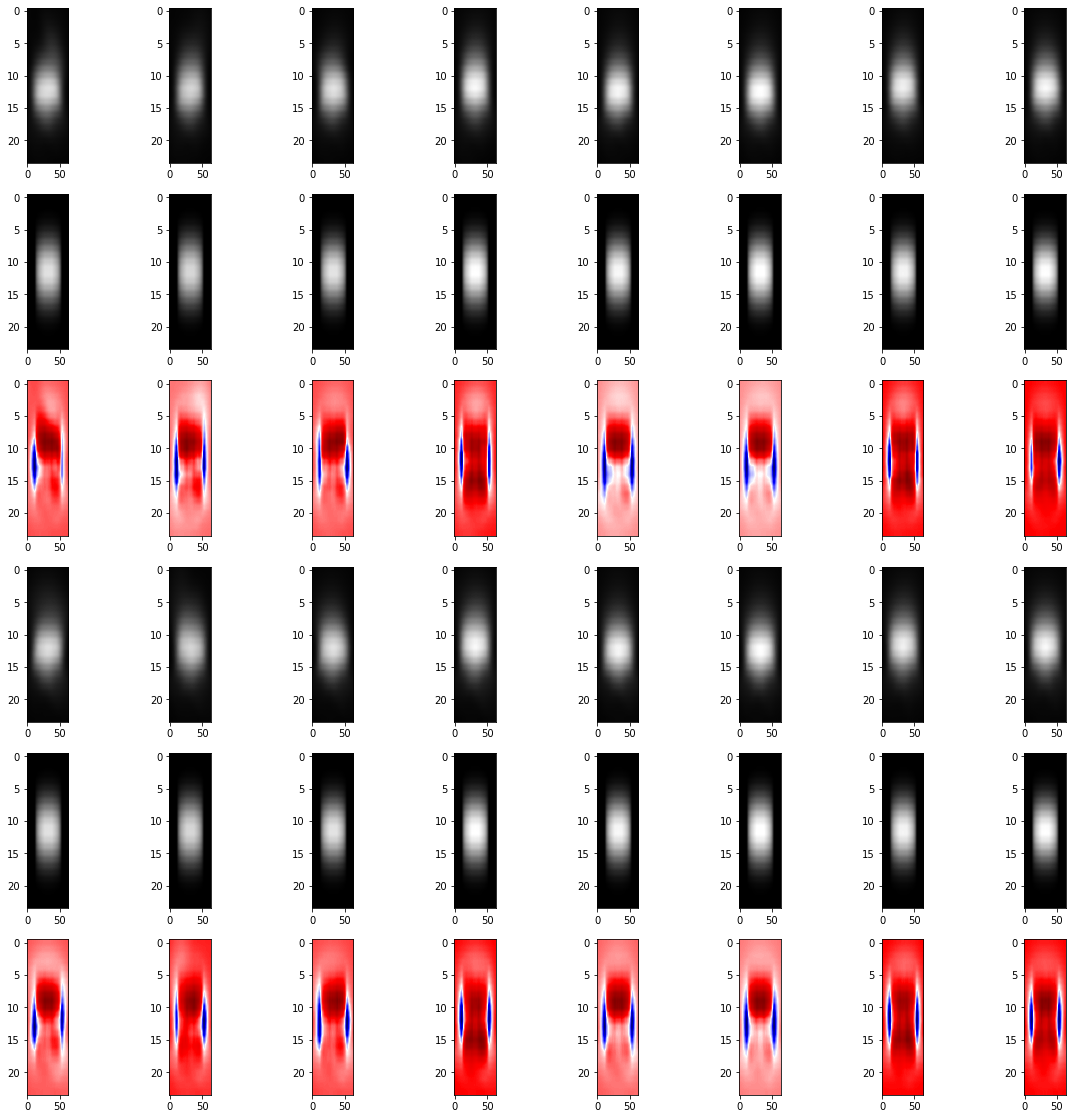

[0.0016062450595200062, 0.0076214224100112915, 0.0012962775072082877, 0.0059004477225244045, 0.0016468893736600876, 0.0019721209537237883, 0.0012480757432058454, 0.0015201501082628965]
stackreg/beads_001_roi000
epoch 0, loss 0.00217395
epoch 10, loss 0.00189145
epoch 20, loss 0.00165879
epoch 30, loss 0.00149139
epoch 40, loss 0.00139425
epoch 50, loss 0.00135485
epoch 60, loss 0.00134663
epoch 70, loss 0.00134632
epoch 80, loss 0.00134540
epoch 90, loss 0.00134420
stackreg/beads_001_roi001
epoch 0, loss 0.00814864
epoch 10, loss 0.00788470
epoch 20, loss 0.00766917
epoch 30, loss 0.00751731
epoch 40, loss 0.00743277
epoch 50, loss 0.00740094
epoch 60, loss 0.00739526
epoch 70, loss 0.00739515
epoch 80, loss 0.00739426
epoch 90, loss 0.00739322
stackreg/beads_001_roi002
epoch 0, loss 0.00185274
epoch 10, loss 0.00157028
epoch 20, loss 0.00134038
epoch 30, loss 0.00117805
epoch 40, loss 0.00108691
epoch 50, loss 0.00105221
epoch 60, loss 0.00104598
epoch 70, loss 0.00104585
epoch 80, lo

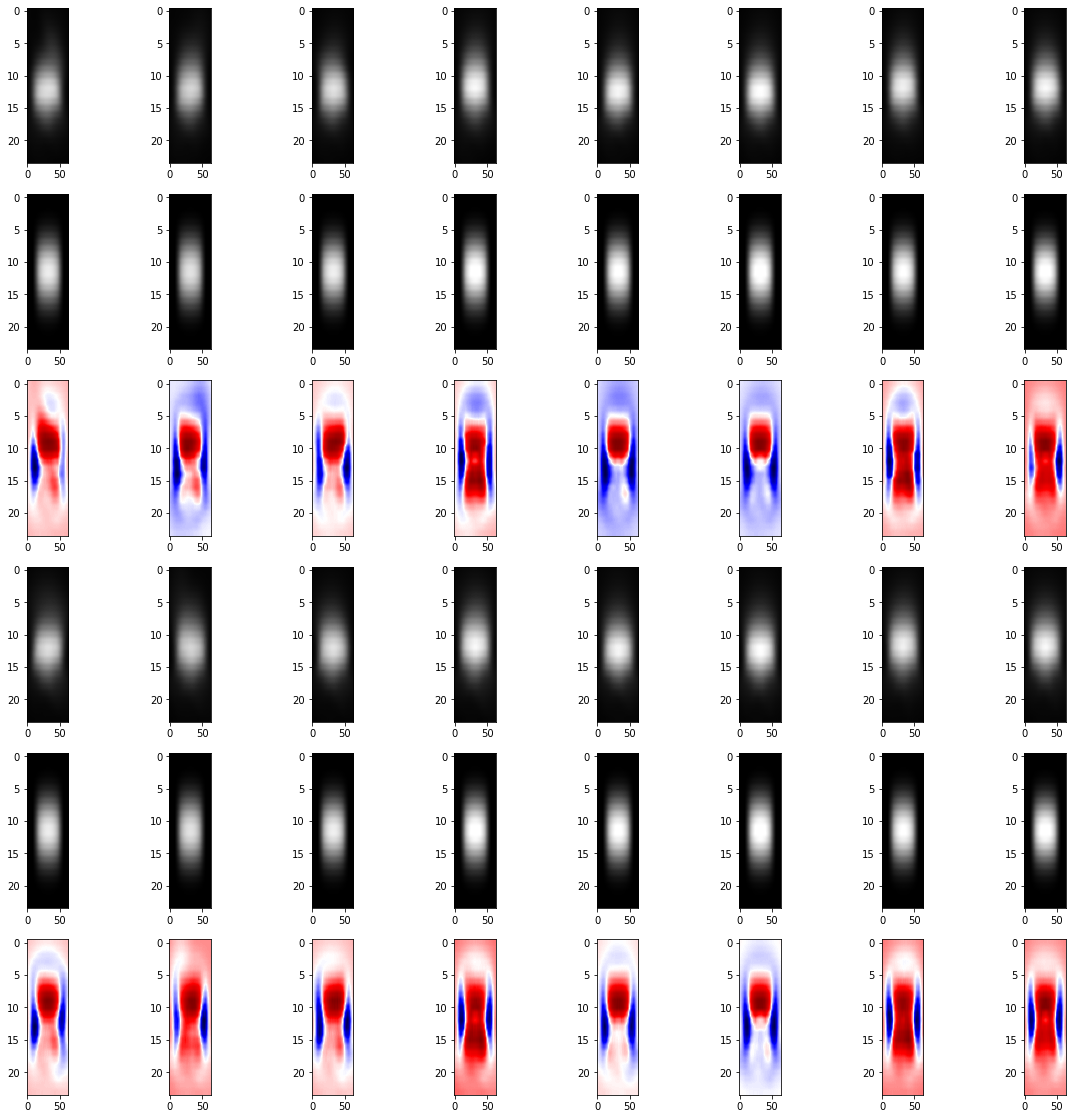

[0.001343564479611814, 0.007392687723040581, 0.00104308663867414, 0.005579154938459396, 0.0013445464428514242, 0.001620264258235693, 0.0009684868855401874, 0.0012002362636849284]
stackreg/beads_001_roi000
epoch 0, loss 0.00217507
epoch 10, loss 0.00184313
epoch 20, loss 0.00157225
epoch 30, loss 0.00135371
epoch 40, loss 0.00117255
epoch 50, loss 0.00102326
epoch 60, loss 0.00090377
epoch 70, loss 0.00081332
epoch 80, loss 0.00074953
epoch 90, loss 0.00070758
stackreg/beads_001_roi001
epoch 0, loss 0.00815002
epoch 10, loss 0.00783825
epoch 20, loss 0.00758668
epoch 30, loss 0.00739165
epoch 40, loss 0.00723976
epoch 50, loss 0.00712125
epoch 60, loss 0.00703100
epoch 70, loss 0.00696602
epoch 80, loss 0.00692275
epoch 90, loss 0.00689594
stackreg/beads_001_roi002
epoch 0, loss 0.00187511
epoch 10, loss 0.00153988
epoch 20, loss 0.00126987
epoch 30, loss 0.00106270
epoch 40, loss 0.00090069
epoch 50, loss 0.00077127
epoch 60, loss 0.00066829
epoch 70, loss 0.00058981
epoch 80, loss 0.0

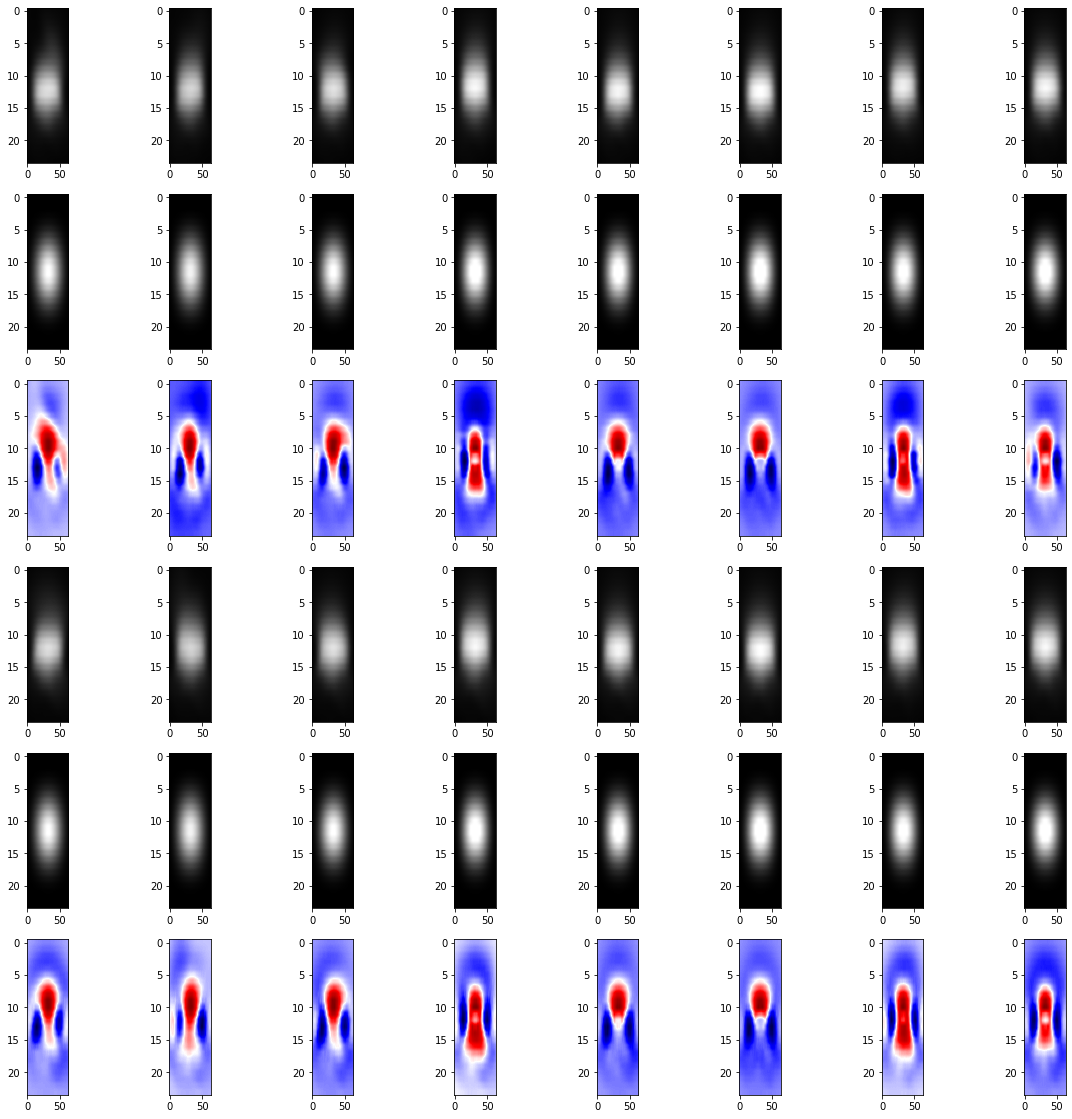

[0.0006834962405264378, 0.006881402805447578, 0.00047583499690517783, 0.004972068592905998, 0.0007150477031245828, 0.0008839474758133292, 0.0004427439416758716, 0.0004963860264979303]
stackreg/beads_001_roi000
epoch 0, loss 0.00217769
epoch 10, loss 0.00184367
epoch 20, loss 0.00157244
epoch 30, loss 0.00135494
epoch 40, loss 0.00117495
epoch 50, loss 0.00102361
epoch 60, loss 0.00089552
epoch 70, loss 0.00079093
epoch 80, loss 0.00071341
epoch 90, loss 0.00066061
stackreg/beads_001_roi001
epoch 0, loss 0.00815240
epoch 10, loss 0.00783871
epoch 20, loss 0.00758679
epoch 30, loss 0.00739249
epoch 40, loss 0.00724164
epoch 50, loss 0.00712176
epoch 60, loss 0.00702467
epoch 70, loss 0.00694870
epoch 80, loss 0.00689572
epoch 90, loss 0.00686252
stackreg/beads_001_roi002
epoch 0, loss 0.00187808
epoch 10, loss 0.00154055
epoch 20, loss 0.00127000
epoch 30, loss 0.00106328
epoch 40, loss 0.00090261
epoch 50, loss 0.00077292
epoch 60, loss 0.00066473
epoch 70, loss 0.00057568
epoch 80, los

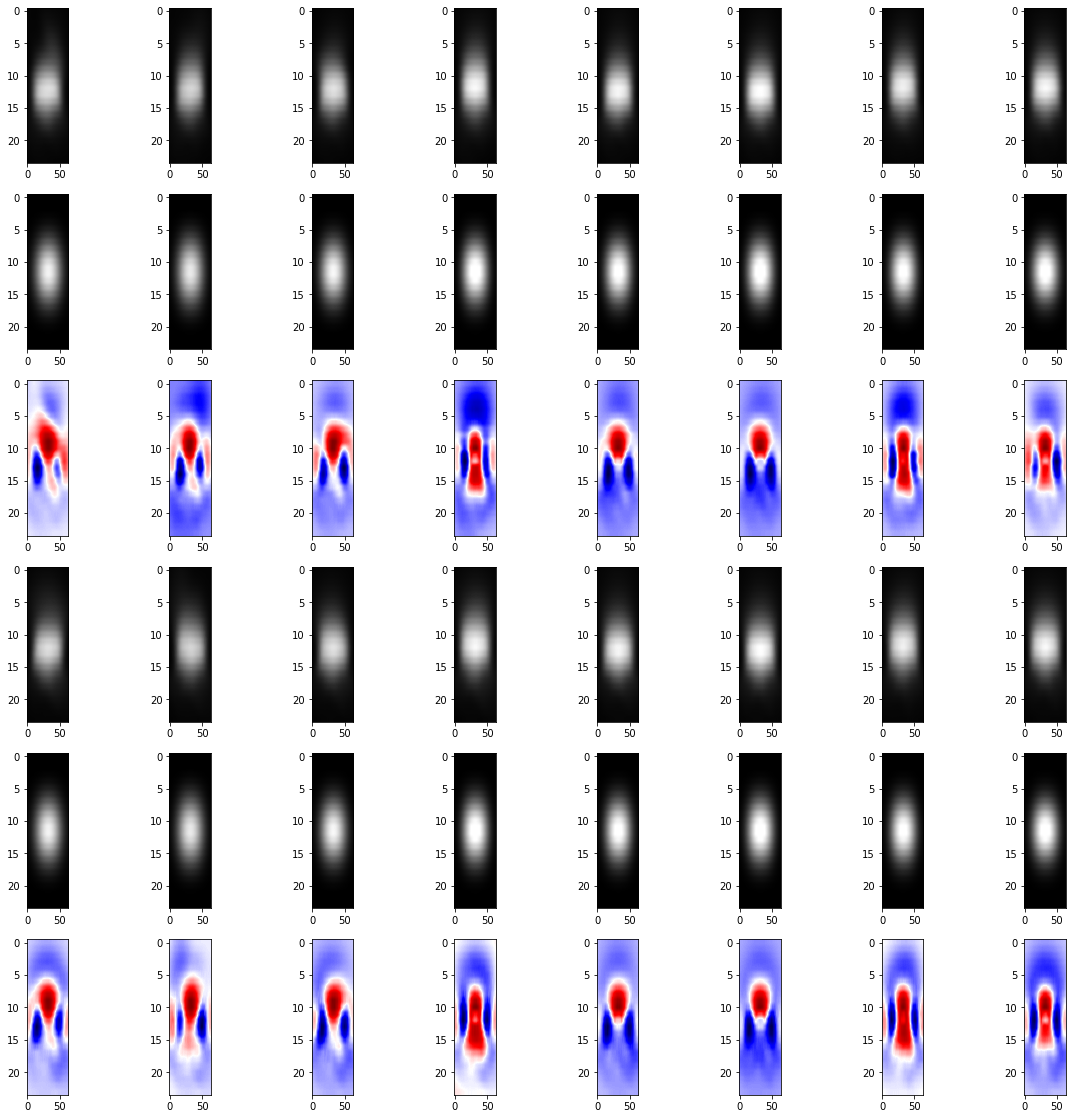

[0.0006305397255346179, 0.006845209281891584, 0.00043824277236126363, 0.0049494849517941475, 0.0006850848440080881, 0.0008546472527086735, 0.00041969932499341667, 0.00046377157559618354]


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
kernels = [3, 9, 31, 61]
lossnames = ["ker3", "ker9", "ker31", "ker61"]
dc = {}
z = 161
for ker, lossname in zip(kernels, lossnames):
    x = ker
    y = ker
    params = {"mu_z"       : 0.2    ,
              "sig_z"      : 0.2    ,
              "log_bet_z"  : np.log(20.).item(),
              "log_bet_xy" : np.log(5.).item(),
              "log_k"  : np.log(1.).item(),
              "log_l"  : np.log(1.).item(),
              "sig_eps"    : 0.01   ,
              "scale"      : 10
              }
    beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
    beadslist.pop(-1)
    losses = []
    fig, ax = plt.subplots(nrows = 6, ncols=len(beadslist), figsize=(20, 20))
    for i, bead in enumerate(beadslist):
        dirpath = "_beads_roi_extracted_stackreg"
        label = torch.load(bead, map_location="cuda").to(torch.float32)
        blur = ImagingProcess(device       = device           ,
                              params       = params           ,
                              z            = z                ,
                              x            = x                ,
                              y            = y                ,
                              mode         = "train"          ,
                              dist         = "gaussian"       ,
                              apply_hill   = False            ,
                              use_fftconv  = True             ,
                              )
        optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
        print(bead[21:-3])
        loss = train_loop(obj, blur, label, optimizer, 100)
        label = label.detach().to("cpu")
        x_label = label[0, :, 64, 32:96]
        y_label = label[0, :, 32:96, 64]
        t = data.to(device).unsqueeze(0)
        t = blur(t).squeeze(0)
        t = t.detach().to('cpu')
        x_img = t[0, :, 64, 32:96]
        y_img = t[0, :, 32:96, 64]
        ax[0, i].imshow(x_label, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[1, i].imshow(x_img, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[2, i].imshow((x_img - x_label + 1) / 2, aspect=10, cmap='seismic')
        ax[3, i].imshow(y_label, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[4, i].imshow(y_img, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[5, i].imshow((y_img - y_label + 1) / 2, aspect=10, cmap='seismic')
        losses.append(loss)
    plt.show()
    print(losses)
    dc[f"{lossname}"] = losses

In [9]:
dc

{'ker3': [0.0016062450595200062,
  0.0076214224100112915,
  0.0012962775072082877,
  0.0059004477225244045,
  0.0016468893736600876,
  0.0019721209537237883,
  0.0012480757432058454,
  0.0015201501082628965],
 'ker9': [0.001343564479611814,
  0.007392687723040581,
  0.00104308663867414,
  0.005579154938459396,
  0.0013445464428514242,
  0.001620264258235693,
  0.0009684868855401874,
  0.0012002362636849284],
 'ker31': [0.0006834962405264378,
  0.006881402805447578,
  0.00047583499690517783,
  0.004972068592905998,
  0.0007150477031245828,
  0.0008839474758133292,
  0.0004427439416758716,
  0.0004963860264979303],
 'ker61': [0.0006305397255346179,
  0.006845209281891584,
  0.00043824277236126363,
  0.0049494849517941475,
  0.0006850848440080881,
  0.0008546472527086735,
  0.00041969932499341667,
  0.00046377157559618354]}